In [409]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types as ptypes

from matplotlib.ticker import MaxNLocator # <-- WAŻNY IMPORT
from typing import List, Union, Literal, Optional, Dict, Any

In [410]:
def wczytaj_dane(sciezka: str):
    return pd.read_csv(sciezka)

In [411]:
def polacz_dane(
    dane1: pd.DataFrame, 
    dane2: pd.DataFrame, 
    klucz: Union[str, List[str]], 
    jak: Literal["inner", "left", "right", "outer"] = "inner"
) -> pd.DataFrame:
    """
    Łączy dwie ramki danych pandas na podstawie klucza, ignorując wielkość liter
    w nazwach kolumn. Dodatkowo, standaryzuje typy danych w połączonej ramce.

    Po połączeniu, kolumny 'country' i 'region' są konwertowane na typ string,
    a wszystkie pozostałe kolumny na typ numeryczny. Wartości, których nie można
    przekonwertować na liczbę, są zamieniane na NaN.

    Args:
        dane1 (pd.DataFrame): Pierwsza ramka danych do połączenia.
        dane2 (pd.DataFrame): Druga ramka danych do połączenia.
        klucz (Union[str, List[str]]): Nazwa kolumny/kolumn klucza. Może być
                                       stringiem lub listą stringów.
        jak (str, optional): Typ połączenia ('inner', 'left', 'right', 'outer').
                             Domyślnie 'inner'.

    Returns:
        pd.DataFrame: Połączona ramka danych ze standaryzowanymi nazwami kolumn
                      (małe litery) i ustandaryzowanymi typami danych.
        
    Raises:
        ValueError: Jeśli któryś ze standaryzowanych kluczy nie zostanie znaleziony
                    w jednej z ramek danych.
    """
    # 1. Tworzenie kopii, aby uniknąć modyfikacji oryginalnych ramek
    df1 = dane1.copy()
    df2 = dane2.copy()

    # 2. Standaryzacja nazw kolumn
    df1.columns = [col.lower().strip() for col in df1.columns]
    df2.columns = [col.lower().strip() for col in df2.columns]

    # 3. Standaryzacja klucza/kluczy
    if isinstance(klucz, str):
        standardized_keys = [klucz.lower().strip()]
    else:
        standardized_keys = [k.lower().strip() for k in klucz]

    # 4. Sprawdzenie, czy klucze istnieją w obu ramkach
    for key in standardized_keys:
        if key not in df1.columns:
            raise ValueError(f"Klucz '{key}' nie został znaleziony w kolumnach pierwszej ramki danych.")
        if key not in df2.columns:
            raise ValueError(f"Klucz '{key}' nie został znaleziony w kolumnach drugiej ramki danych.")

    # 5. Wykonanie połączenia
    merged_df = pd.merge(df1, df2, on=standardized_keys, how=jak)

    # --- NOWA SEKCJA: 6. Standaryzacja typów danych ---
    print("Standaryzacja typów danych po połączeniu...")
    
    # Zdefiniowanie kolumn, które mają pozostać jako tekst
    string_cols = ['country', 'region']

    for col in merged_df.columns:
        if col in string_cols:
            # Upewniamy się, że kolumny tekstowe mają typ 'string'
            merged_df[col] = merged_df[col].astype(str)
        else:
            # Wszystkie pozostałe kolumny próbujemy przekonwertować na typ numeryczny
            # errors='coerce' zamieni wszelkie błędy (np. tekst) na NaN
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

    return merged_df

In [412]:
def skategoryzuj_kolumne_numeryczna(
    dane: pd.DataFrame,
    nazwa_kolumny: str,
    grupy_niestandardowe: Optional[Dict[str, str]] = None,
    co_ile: Optional[int] = None
) -> pd.DataFrame:
    """
    Kategoryzuje kolumnę numeryczną. Jeśli kolumna jest już nienumeryczna,
    informuje o tym i zwraca dane bez zmian.

    Działa w jednym z dwóch trybów:
    1. Jeśli podano `grupy_niestandardowe`: kategoryzuje wg słownika przedziałów.
    2. Jeśli podano `co_ile`: automatycznie tworzy przedziały o stałej szerokości.

    Args:
        dane (pd.DataFrame): Ramka danych do modyfikacji.
        nazwa_kolumny (str): Nazwa kolumny numerycznej do skategoryzowania.
        grupy_niestandardowe (Dict, optional): Słownik niestandardowych grup.
        co_ile (int, optional): Wartość kroku do automatycznego tworzenia grup.

    Returns:
        pd.DataFrame: Nowa ramka danych ze skategoryzowaną kolumną.
        
    Raises:
        ValueError: Jeśli wystąpią błędy w argumentach wejściowych.
    """
    # --- 1. Walidacja argumentów i sprawdzenie typu kolumny ---
    if nazwa_kolumny not in dane.columns:
        raise ValueError(f"Kolumna '{nazwa_kolumny}' nie istnieje w ramce danych!")
        
    # NOWOŚĆ: Sprawdzenie, czy kolumna jest już kategoryczna (tzn. nienumeryczna)
    if not ptypes.is_numeric_dtype(dane[nazwa_kolumny]):
        print(f"Informacja: Kolumna '{nazwa_kolumny}' jest już typu nienumerycznego ({dane[nazwa_kolumny].dtype}). Prawdopodobnie została już skategoryzowana.")
        print("Zwracam oryginalną ramkę danych bez zmian.")
        return dane.copy() # Zwracamy kopię, aby zachować spójność
        
    if grupy_niestandardowe and co_ile:
        raise ValueError("Podaj 'grupy_niestandardowe' ALBO 'co_ile', nie oba naraz.")
        
    if not grupy_niestandardowe and not co_ile:
        raise ValueError("Musisz podać jedną z opcji kategoryzacji: 'grupy_niestandardowe' lub 'co_ile'.")

    df_roboczy = dane.copy()
    
    # Mimo sprawdzenia, ta linia jest nadal użyteczna do obsługi np. kolumn mieszanych
    oryginalne_wartosci = pd.to_numeric(df_roboczy[nazwa_kolumny], errors='coerce')
    etykiety = oryginalne_wartosci.astype(str)

    # --- 2. Wybór i wykonanie trybu kategoryzacji ---
    if grupy_niestandardowe:
        print(f"Tryb: Niestandardowe grupy dla kolumny '{nazwa_kolumny}'.")
        for start_str, end_str in grupy_niestandardowe.items():
            try:
                start = int(start_str)
                end = int(end_str)
            except (ValueError, TypeError):
                raise ValueError(f"Słownik grup może zawierać tylko wartości numeryczne. Błąd w parze: {start_str}:{end_str}")

            etykieta = f"{start}-{end}"
            warunek = (oryginalne_wartosci >= start) & (oryginalne_wartosci <= end)
            etykiety.loc[warunek] = etykieta
    
    elif co_ile:
        print(f"Tryb: Automatyczne grupy co {co_ile} dla kolumny '{nazwa_kolumny}'.")
        wartosci_bez_nan = oryginalne_wartosci.dropna()
        start_przedzialu = (wartosci_bez_nan // co_ile) * co_ile
        koniec_przedzialu = start_przedzialu + co_ile - 1
        nowe_etykiety = start_przedzialu.astype(int).astype(str) + '-' + koniec_przedzialu.astype(int).astype(str)
        etykiety.loc[wartosci_bez_nan.index] = nowe_etykiety

    # --- 3. Zastąpienie kolumny i zwrot wyniku ---
    df_roboczy[nazwa_kolumny] = etykiety
    print("Kategoryzacja zakończona.")
    return df_roboczy

In [413]:
def filtruj_dane(
    dane: pd.DataFrame,
    filtry: Dict[str, List[Any]]
) -> pd.DataFrame:
    """
    Filtruje ramkę danych na podstawie dynamicznie zdefiniowanych warunków.

    Funkcja stosuje wszystkie warunki podane w słowniku `filtry` 
    za pomocą operatora logicznego AND (wszystkie muszą być spełnione).

    Args:
        dane (pd.DataFrame): Ramka danych do przefiltrowania.
        filtry (Dict[str, List[Any]]): Słownik, w którym kluczem jest nazwa
            kolumny, a wartością jest dwuelementowa lista: [operator, wartość].
            
            Obsługiwane operatory:
            - '=', '==' (równy)
            - '!=' (nierówny)
            - '>' (większy niż)
            - '<' (mniejszy niż)
            - '>=' (większy lub równy)
            - '<=' (mniejszy lub równy)
            - 'in' (zawarty w liście)
            - 'not in' (niezawarty w liście)

    Returns:
        pd.DataFrame: Nowa, przefiltrowana ramka danych.
        
    Raises:
        ValueError: Jeśli nazwa kolumny nie istnieje, format warunku jest
                    niepoprawny lub operator jest nieznany.
    """
    # Zaczynamy od kopii, aby nie modyfikować oryginalnych danych
    df_roboczy = dane.copy()

    print(f"Rozpoczynam filtrowanie. Początkowa liczba wierszy: {len(df_roboczy)}")

    # Pętla przez wszystkie warunki zdefiniowane w słowniku
    for kolumna, warunek in filtry.items():
        # --- Walidacja danych wejściowych ---
        if kolumna not in df_roboczy.columns:
            raise ValueError(f"Kolumna '{kolumna}' nie istnieje w ramce danych!")

        if not isinstance(warunek, list) or len(warunek) != 2:
            raise ValueError(f"Format warunku dla kolumny '{kolumna}' jest niepoprawny. Oczekiwano [operator, wartość].")

        operator, wartosc = warunek
        # --- Zastosowanie odpowiedniego filtra ---
        print(f"  - Stosowanie filtra: '{kolumna}' {operator} {wartosc}")
        
        if operator in ['=', '==']:
            df_roboczy = df_roboczy[df_roboczy[kolumna] == wartosc]
        elif operator == '!=':
            df_roboczy = df_roboczy[df_roboczy[kolumna] != wartosc]
        elif operator == '>':
            df_roboczy = df_roboczy[df_roboczy[kolumna] > wartosc]
        elif operator == '>=':
            df_roboczy = df_roboczy[df_roboczy[kolumna] >= wartosc]
        elif operator == '<':
            df_roboczy = df_roboczy[df_roboczy[kolumna] < wartosc]
        elif operator == '<=':
            df_roboczy = df_roboczy[df_roboczy[kolumna] <= wartosc]
        elif operator.lower() == 'in':
            if not isinstance(wartosc, (list, tuple, set)):
                raise ValueError(f"Dla operatora 'in' wartość musi być listą lub krotką. Otrzymano {type(wartosc)}.")
            df_roboczy = df_roboczy[df_roboczy[kolumna].isin(wartosc)]
        elif operator.lower() == 'not in':
            if not isinstance(wartosc, (list, tuple, set)):
                raise ValueError(f"Dla operatora 'not in' wartość musi być listą lub krotką. Otrzymano {type(wartosc)}.")
            df_roboczy = df_roboczy[~df_roboczy[kolumna].isin(wartosc)]
        else:
            raise ValueError(f"Nieznany operator '{operator}' dla kolumny '{kolumna}'.")

    print(f"Filtrowanie zakończone. Końcowa liczba wierszy: {len(df_roboczy)}")
    return df_roboczy

In [414]:
def wykres_liniowy(
    dane: pd.DataFrame, 
    kolumna_1: str, 
    kolumna_2: str, 
    grupa: Optional[str] = None,
    rozmiar: tuple = (16, 9),
    paleta: str = "viridis",
    tytul: Optional[str] = None,
    ile_tickow_x: Optional[int] = None, # NOWOŚĆ: Kontrola osi X
    ile_tickow_y: Optional[int] = None, # NOWOŚĆ: Kontrola osi Y
    tylko_calkowite_x: bool = False     # NOWOŚĆ: Wymuszenie liczb całkowitych na osi X
):
    """
    Tworzy estetyczny wykres liniowy z zaawansowaną kontrolą nad gęstością osi.
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=rozmiar)
    fig.set_facecolor("white")
    ax.set_facecolor((0.95, 0.95, 0.97))

    if grupa:
        sns.lineplot(data=dane, x=kolumna_1, y=kolumna_2, hue=grupa, style=grupa,
                     markers=True, dashes=False, palette=paleta, linewidth=2.5, 
                     legend=False, ax=ax)
    else:
        sns.lineplot(data=dane, x=kolumna_1, y=kolumna_2, markers=True, 
                     linewidth=2.5, color=sns.color_palette(paleta, 1)[0], ax=ax)

    label_x = kolumna_1.replace('_', ' ').capitalize()
    label_y = kolumna_2.replace('_', ' ').capitalize()
    
    if tytul is None:
        tytul = f"Zależność '{label_y}' od '{label_x}'"
        if grupa: tytul += f" w podziale na '{grupa.replace('_', ' ').capitalize()}'"

    ax.set_title(tytul, fontsize=20, weight='bold', pad=20)
    ax.set_xlabel(label_x, fontsize=14, weight='semibold')
    ax.set_ylabel(label_y, fontsize=14, weight='semibold')
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    plt.setp(ax.get_xticklabels(), ha="right")

    if grupa:
        for kategoria in dane[grupa].unique():
            subset = dane[dane[grupa] == kategoria].sort_values(by=kolumna_1)
            if not subset.empty:
                last_point = subset.iloc[-1]
                ax.text(x=last_point[kolumna_1], y=last_point[kolumna_2],
                        s=f'  {kategoria}', fontsize=12, weight='medium',
                        verticalalignment='center')
        ax.set_xlim(dane[kolumna_1].min(), dane[kolumna_1].max() * 1.05)
        
    # --- KONTROLA OSI ---
    if ile_tickow_x:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=ile_tickow_x, integer=tylko_calkowite_x))
    if ile_tickow_y:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=ile_tickow_y))

    sns.despine(ax=ax)
    fig.tight_layout()
    plt.show()

In [415]:
def wykres_punktowy(
    dane: pd.DataFrame, 
    kolumna_1: str, 
    kolumna_2: str, 
    grupa: Optional[str] = None,
    rozmiar_punktow_wg: Optional[str] = None,
    pokaz_trend: bool = False,
    rozmiar: tuple = (16, 9),
    paleta: str = "rainbow",
    tytul: Optional[str] = None,
    ile_tickow_x: Optional[int] = None,
    ile_tickow_y: Optional[int] = None
):
    """
    Tworzy estetyczny wykres punktowy z inteligentnym układem i czystą legendą.
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=rozmiar, constrained_layout=True)
    fig.set_facecolor("white")
    ax.set_facecolor((0.95, 0.95, 0.97))

    sns.scatterplot(
        data=dane,
        x=kolumna_1,
        y=kolumna_2,
        hue=grupa,
        # style=grupa, <-- USUNIĘTA LINIA
        size=rozmiar_punktow_wg,
        sizes=(50, 400) if rozmiar_punktow_wg else None,
        palette=paleta,
        alpha=0.8,
        legend="auto",
        ax=ax
    )

    if pokaz_trend:
        sns.regplot(data=dane, x=kolumna_1, y=kolumna_2, scatter=False, ax=ax,
                    color='darkgray', line_kws={'linestyle':'--'})

    label_x = kolumna_1.replace('_', ' ').capitalize()
    label_y = kolumna_2.replace('_', ' ').capitalize()
    
    if tytul is None:
        tytul = f"Zależność między '{label_y}' a '{label_x}'"
        if grupa: tytul += f" w podziale na '{grupa.replace('_', ' ').capitalize()}'"

    ax.set_title(tytul, fontsize=20, weight='bold', pad=20)
    ax.set_xlabel(label_x, fontsize=14, weight='semibold')
    ax.set_ylabel(label_y, fontsize=14, weight='semibold')
    ax.tick_params(axis='both', labelsize=12)

    if grupa or rozmiar_punktow_wg:
        leg = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    if ile_tickow_x:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=ile_tickow_x))
    if ile_tickow_y:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=ile_tickow_y))

    sns.despine(ax=ax)
    plt.show()

In [416]:
def wykres_babelkowy(
    dane: pd.DataFrame,
    kolumna_x: str,
    kolumna_y: str,
    kolumna_rozmiar: str,
    grupa: Optional[str] = None,
    rozmiar: tuple = (16, 10),
    max_rozmiar_babelka: int = 1500,
    paleta: str = "viridis",
    tytul: Optional[str] = None,
    ile_tickow_x: Optional[int] = None,
    ile_tickow_y: Optional[int] = None
):
    """
    Tworzy estetyczny i informacyjny wykres bąbelkowy (bubble chart).

    Wizualizuje zależność między dwiema zmiennymi (osie X i Y), gdzie rozmiar
    bąbelka reprezentuje trzecią zmienną numeryczną. Opcjonalnie, kolor
    bąbelka może reprezentować czwartą zmienną kategoryczną.

    Args:
        dane (pd.DataFrame): Ramka danych do wizualizacji.
        kolumna_x (str): Nazwa kolumny numerycznej na oś X.
        kolumna_y (str): Nazwa kolumny numerycznej na oś Y.
        kolumna_rozmiar (str): Nazwa kolumny numerycznej sterującej rozmiarem bąbelków.
        grupa (str, optional): Nazwa kolumny kategorycznej do kolorowania bąbelków.
        rozmiar (tuple, optional): Rozmiar wykresu w calach.
        max_rozmiar_babelka (int, optional): Maksymalny rozmiar bąbelka na wykresie.
        paleta (str, optional): Nazwa palety kolorów Seaborn.
        tytul (str, optional): Niestandardowy tytuł wykresu.
        ile_tickow_x (int, optional): Sugerowana liczba znaczników na osi X.
        ile_tickow_y (int, optional): Sugerowana liczba znaczników na osi Y.
    """
    # --- 1. Ustawienia estetyczne i stworzenie figury ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=rozmiar, constrained_layout=True)
    fig.set_facecolor("white")
    ax.set_facecolor((0.95, 0.95, 0.97))

    # --- 2. Stworzenie głównego wykresu ---
    sns.scatterplot(
        data=dane,
        x=kolumna_x,
        y=kolumna_y,
        size=kolumna_rozmiar, # Kluczowy parametr dla wykresu bąbelkowego
        hue=grupa,
        palette=paleta,
        sizes=(40, max_rozmiar_babelka), # Zakres rozmiarów bąbelków
        alpha=0.7, # Przezroczystość, aby bąbelki na siebie nie nachodziły
        legend="auto",
        ax=ax
    )

    # --- 3. Dodanie informacyjnych etykiet i tytułu ---
    label_x = kolumna_x.replace('_', ' ').capitalize()
    label_y = kolumna_y.replace('_', ' ').capitalize()
    label_rozmiar = kolumna_rozmiar.replace('_', ' ').capitalize()
    
    if tytul is None:
        tytul = f"Zależność '{label_y}' od '{label_x}', rozmiar bąbelka wg '{label_rozmiar}'"
        if grupa:
            tytul += f" w podziale na '{grupa.replace('_', ' ').capitalize()}'"

    ax.set_title(tytul, fontsize=20, weight='bold', pad=20)
    ax.set_xlabel(label_x, fontsize=14, weight='semibold')
    ax.set_ylabel(label_y, fontsize=14, weight='semibold')
    ax.tick_params(axis='both', labelsize=12)

    # --- 4. Poprawki legendy ---
    # Przesuwamy legendę na zewnątrz, aby nie zasłaniała danych
    if grupa or kolumna_rozmiar:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # --- 5. Kontrola osi ---
    if ile_tickow_x:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=ile_tickow_x))
    if ile_tickow_y:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=ile_tickow_y))

    # --- 6. Finalne poprawki i wyświetlenie ---
    sns.despine(ax=ax)
    plt.show()

In [417]:
def wykres_korelacji(
    dane: pd.DataFrame,
    rozmiar: tuple = (12, 10),
    paleta: str = "coolwarm",
    tytul: Optional[str] = None
):
    """
    Tworzy i wyświetla estetyczny korelogram (heatmap) dla zmiennych numerycznych.

    Funkcja automatycznie wybiera kolumny numeryczne, oblicza macierz korelacji
    metodą Pearsona i wizualizuje ją jako mapę ciepła. Górna połowa macierzy
    jest zamaskowana dla lepszej czytelności.

    Args:
        dane (pd.DataFrame): Ramka danych do analizy.
        rozmiar (tuple, optional): Rozmiar wykresu w calach.
        paleta (str, optional): Nazwa rozbieżnej palety kolorów. Domyślnie 'coolwarm'.
        tytul (str, optional): Niestandardowy tytuł wykresu.
    """
    # --- 1. Wybór tylko kolumn numerycznych ---
    df_numeryczne = dane.select_dtypes(include=np.number)
    
    if df_numeryczne.shape[1] < 2:
        print("Informacja: W ramce danych znaleziono mniej niż dwie kolumny numeryczne. Nie można utworzyć korelogramu.")
        return

    # --- 2. Obliczenie macierzy korelacji ---
    macierz_korelacji = df_numeryczne.corr(method='pearson')

    # --- 3. Stworzenie maski do ukrycia górnej połowy wykresu ---
    # To kluczowy krok dla czytelności!
    # maska = np.triu(np.ones_like(macierz_korelacji, dtype=bool))
    maska = np.zeros_like(macierz_korelacji, dtype=bool)
    
    # --- 4. Ustawienia estetyczne i stworzenie figury ---
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=rozmiar, constrained_layout=True)
    fig.set_facecolor("white")

    # --- 5. Stworzenie głównego wykresu (heatmap) ---
    sns.heatmap(
        macierz_korelacji,
        mask=maska,
        cmap=paleta,
        annot=True,          # Wyświetl wartości w komórkach
        fmt=".2f",           # Formatuj wartości do dwóch miejsc po przecinku
        linewidths=.5,
        vmin=-1, vmax=1,     # Zakotwicz skalę kolorów od -1 do 1
        cbar_kws={"shrink": .8}, # Lekko zmniejsz pasek kolorów
        ax=ax
    )

    # --- 6. Dodanie tytułu i poprawki etykiet ---
    if tytul is None:
        tytul = "Korelogram zmiennych numerycznych (metoda Pearsona)"

    ax.set_title(tytul, fontsize=18, weight='bold', pad=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # --- 7. Wyświetlenie wykresu ---
    plt.show()

In [429]:
dane1 = wczytaj_dane("./data/health/health_index.csv")
dane2 = wczytaj_dane("./data/pollution/pollution_index.csv")

In [430]:
polaczone_dane = polacz_dane(dane1, dane2, klucz=["country", "year"])
polaczone_dane

Standaryzacja typów danych po połączeniu...


,rank_x,country,health_care_index,health_care_exp_index,year,rank_y,pollution_index,exp_pollution_index
0,1,Japan,96.1,179.4,2012,45,52.5,74.4
1,2,Indonesia,94.1,175.0,2012,51,43.8,58.0
2,3,Sri Lanka,93.5,174.2,2012,2,135.8,194.5
3,4,Thailand,92.6,173.3,2012,16,101.6,141.1
4,5,Israel,91.7,170.6,2012,48,48.8,69.4
...,...,...,...,...,...,...,...,...
1178,93,Egypt,47.3,81.2,2025,11,82.7,146.9
1179,94,Morocco,46.8,80.2,2025,41,68.4,118.6
1180,95,Iraq,45.9,78.3,2025,37,71.0,123.3
1181,96,Bangladesh,42.2,72.1,2025,7,85.6,153.0


In [420]:
# filtry = {
#     "pollution_index": [">" , 30]
# }

# polaczone_dane = filtruj_dane(polaczone_dane, filtry)

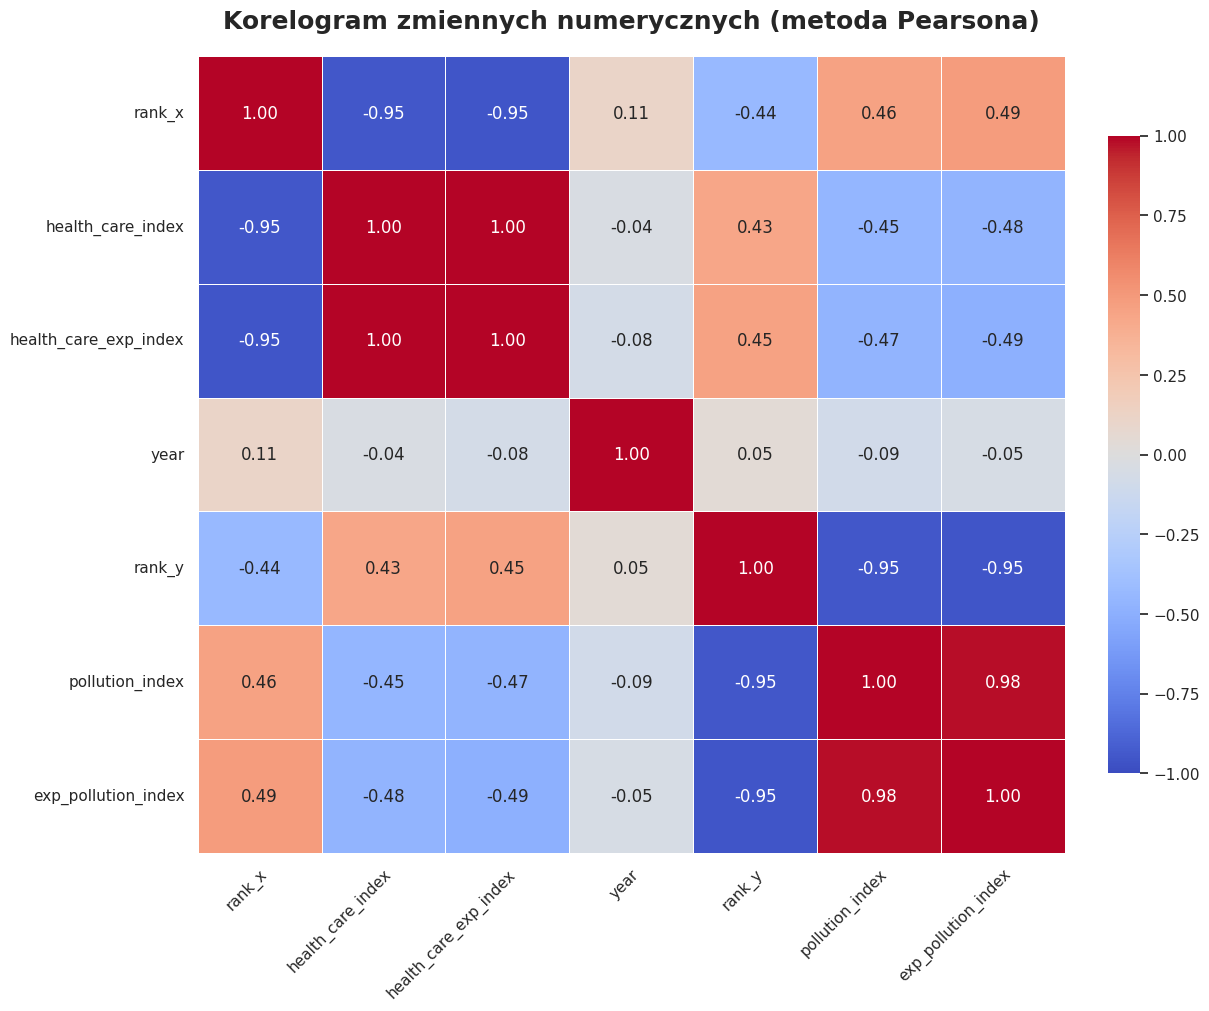

In [431]:
wykres_korelacji(polaczone_dane)

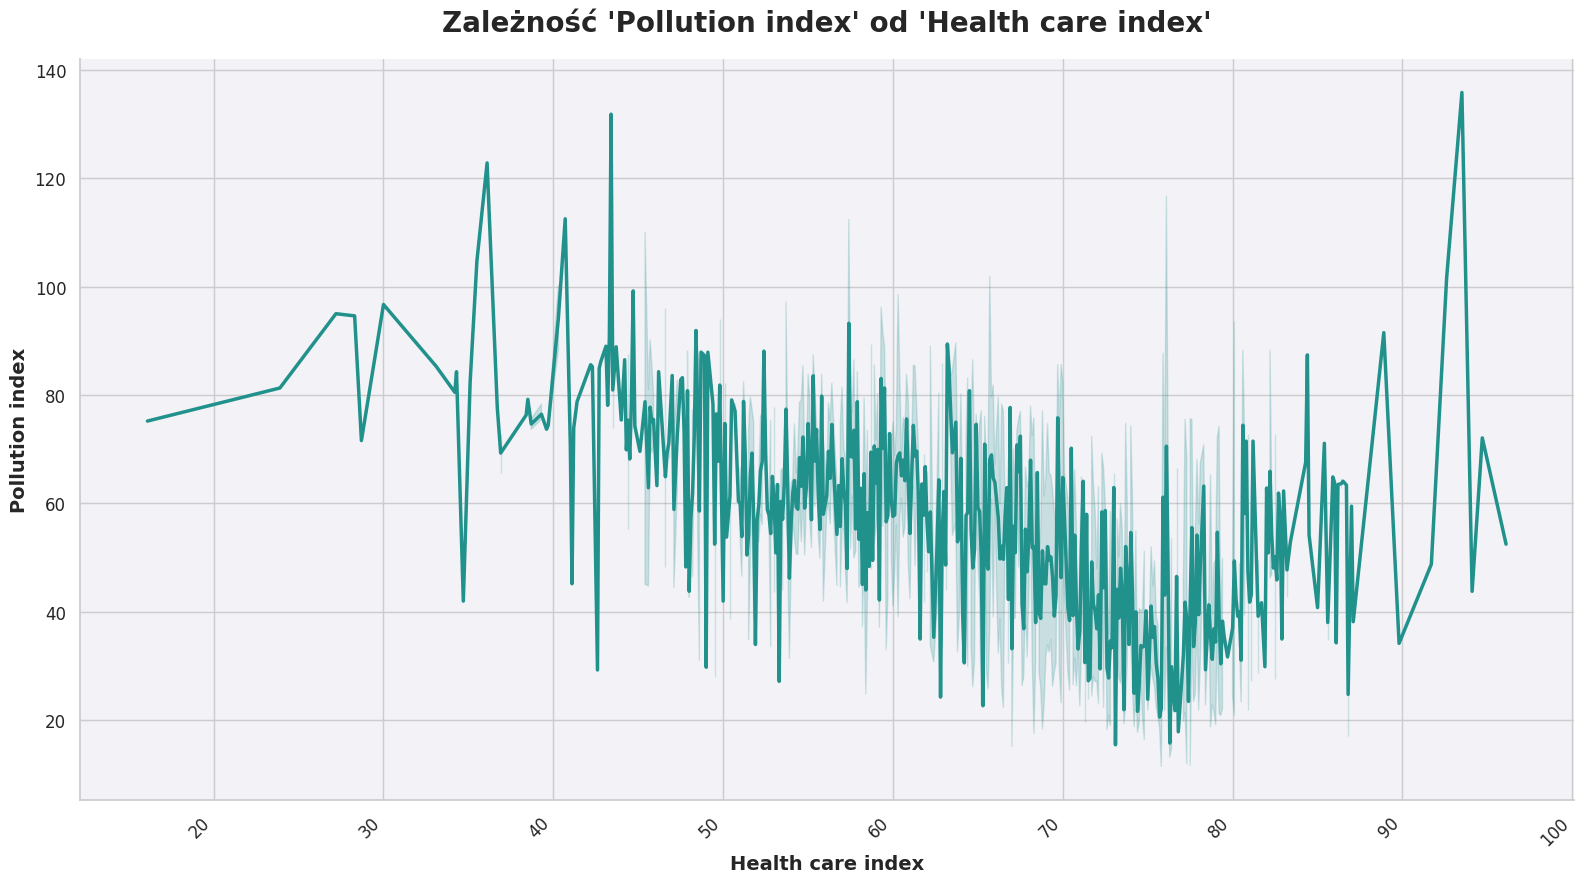

In [422]:
wykres_liniowy(polaczone_dane, "health_care_index", "pollution_index")

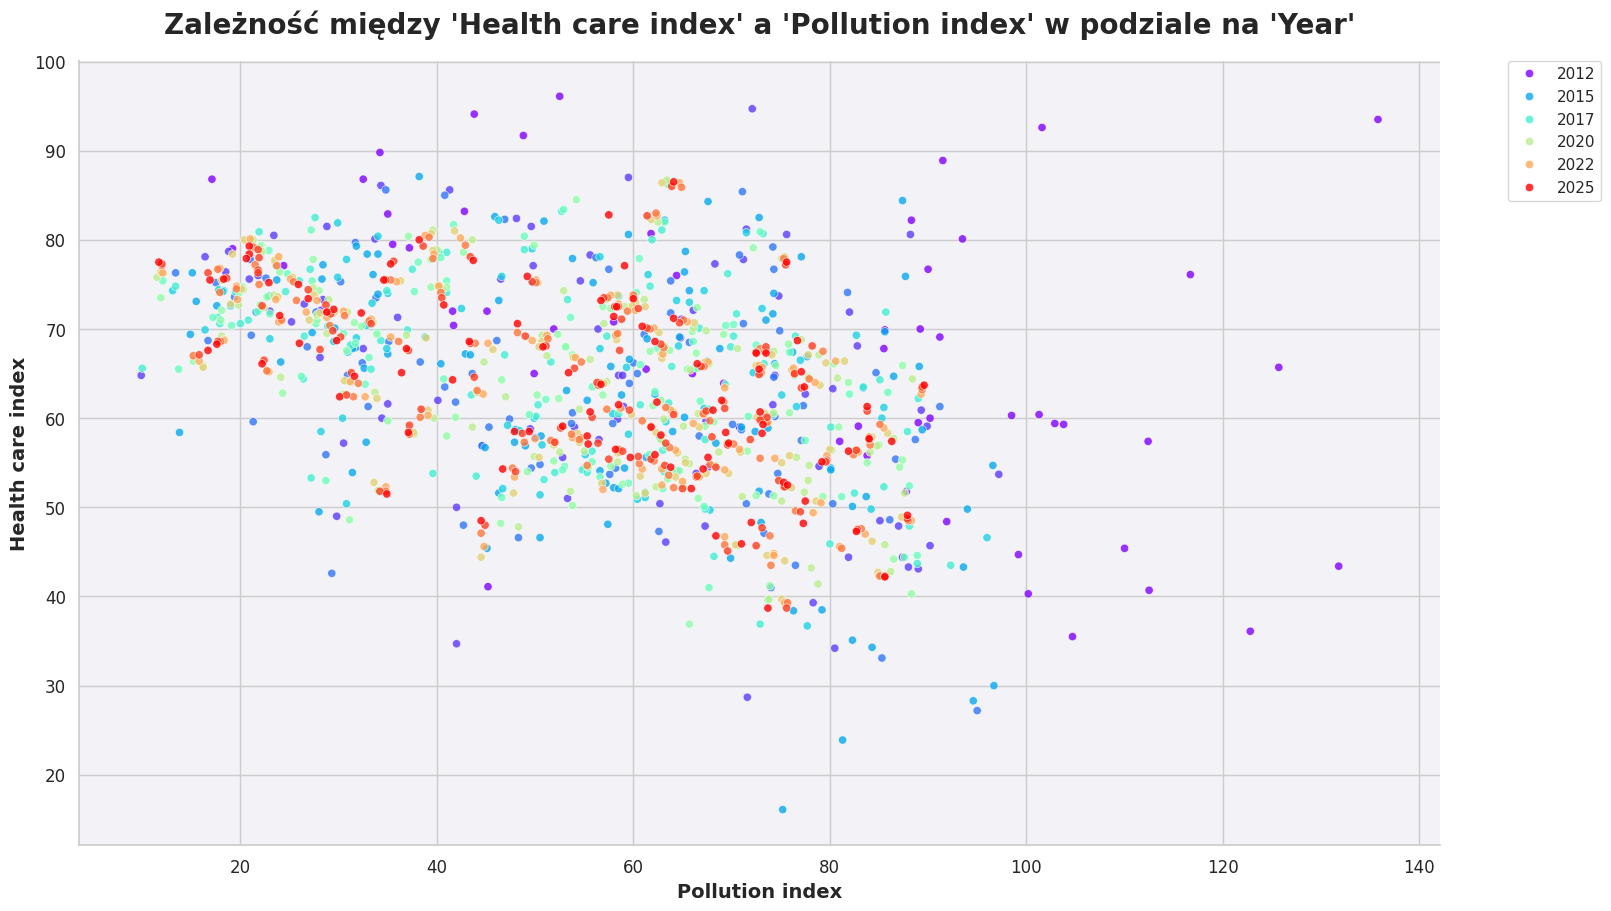

In [423]:
wykres_punktowy(polaczone_dane, "pollution_index", "health_care_index", "year")

In [424]:
dane3 = wczytaj_dane("./data/happiness/happiness_index.csv")

polaczone_dane_nowe = polacz_dane(polaczone_dane, dane3, klucz=["year", "country"])
polaczone_dane_nowe

Standaryzacja typów danych po połączeniu...


,rank_x,country,health_care_index,health_care_exp_index,year,rank_y,pollution_index,exp_pollution_index,rank,life evaluation,...,healthy life expectancy,freedom,generosity,perceptions of corruption,positive emotions,negative emotions,donated,volunteered,helped a stranger,healthy life expectancy (2021 data)
0,1,Japan,96.1,179.4,2012,45,52.5,74.4,43.0,6.064,...,1.0,62.0,NaN,30.0,49.0,20.0,NaN,NaN,NaN,NaN
1,2,Indonesia,94.1,175.0,2012,51,43.8,58.0,76.0,5.348,...,85.0,55.0,11.0,131.0,21.0,60.0,11.0,24.0,95.0,NaN
2,3,Sri Lanka,93.5,174.2,2012,2,135.8,194.5,137.0,4.151,...,55.0,46.0,30.0,74.0,23.0,38.0,30.0,2.0,38.0,NaN
3,4,Thailand,92.6,173.3,2012,16,101.6,141.1,36.0,6.371,...,44.0,35.0,5.0,114.0,32.0,8.0,5.0,92.0,108.0,NaN
4,5,Israel,91.7,170.6,2012,48,48.8,69.4,11.0,7.301,...,5.0,83.0,21.0,89.0,84.0,107.0,21.0,54.0,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,90,Egypt,47.5,81.7,2024,11,82.8,147.0,135.0,3.817,...,NaN,116.0,140.0,NaN,140.0,124.0,140.0,142.0,33.0,88.0
930,91,Iraq,45.7,78.0,2024,34,72.5,126.2,101.0,4.976,...,NaN,134.0,90.0,76.0,121.0,137.0,90.0,91.0,34.0,82.0
931,92,Morocco,45.1,77.0,2024,38,69.6,120.9,112.0,4.622,...,NaN,94.0,142.0,60.0,134.0,118.0,142.0,124.0,52.0,72.0
932,93,Bangladesh,42.3,72.4,2024,7,85.6,153.2,134.0,3.851,...,NaN,12.0,50.0,105.0,137.0,115.0,50.0,94.0,15.0,68.0


In [425]:
grupy_lat = {
    2012:2021,
    2022:2025
}

polaczone_dane_nowe = skategoryzuj_kolumne_numeryczna(polaczone_dane_nowe, "year", grupy_lat)
polaczone_dane_nowe

Tryb: Niestandardowe grupy dla kolumny 'year'.
Kategoryzacja zakończona.


,rank_x,country,health_care_index,health_care_exp_index,year,rank_y,pollution_index,exp_pollution_index,rank,life evaluation,...,healthy life expectancy,freedom,generosity,perceptions of corruption,positive emotions,negative emotions,donated,volunteered,helped a stranger,healthy life expectancy (2021 data)
0,1,Japan,96.1,179.4,2012-2021,45,52.5,74.4,43.0,6.064,...,1.0,62.0,NaN,30.0,49.0,20.0,NaN,NaN,NaN,NaN
1,2,Indonesia,94.1,175.0,2012-2021,51,43.8,58.0,76.0,5.348,...,85.0,55.0,11.0,131.0,21.0,60.0,11.0,24.0,95.0,NaN
2,3,Sri Lanka,93.5,174.2,2012-2021,2,135.8,194.5,137.0,4.151,...,55.0,46.0,30.0,74.0,23.0,38.0,30.0,2.0,38.0,NaN
3,4,Thailand,92.6,173.3,2012-2021,16,101.6,141.1,36.0,6.371,...,44.0,35.0,5.0,114.0,32.0,8.0,5.0,92.0,108.0,NaN
4,5,Israel,91.7,170.6,2012-2021,48,48.8,69.4,11.0,7.301,...,5.0,83.0,21.0,89.0,84.0,107.0,21.0,54.0,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,90,Egypt,47.5,81.7,2022-2025,11,82.8,147.0,135.0,3.817,...,NaN,116.0,140.0,NaN,140.0,124.0,140.0,142.0,33.0,88.0
930,91,Iraq,45.7,78.0,2022-2025,34,72.5,126.2,101.0,4.976,...,NaN,134.0,90.0,76.0,121.0,137.0,90.0,91.0,34.0,82.0
931,92,Morocco,45.1,77.0,2022-2025,38,69.6,120.9,112.0,4.622,...,NaN,94.0,142.0,60.0,134.0,118.0,142.0,124.0,52.0,72.0
932,93,Bangladesh,42.3,72.4,2022-2025,7,85.6,153.2,134.0,3.851,...,NaN,12.0,50.0,105.0,137.0,115.0,50.0,94.0,15.0,68.0


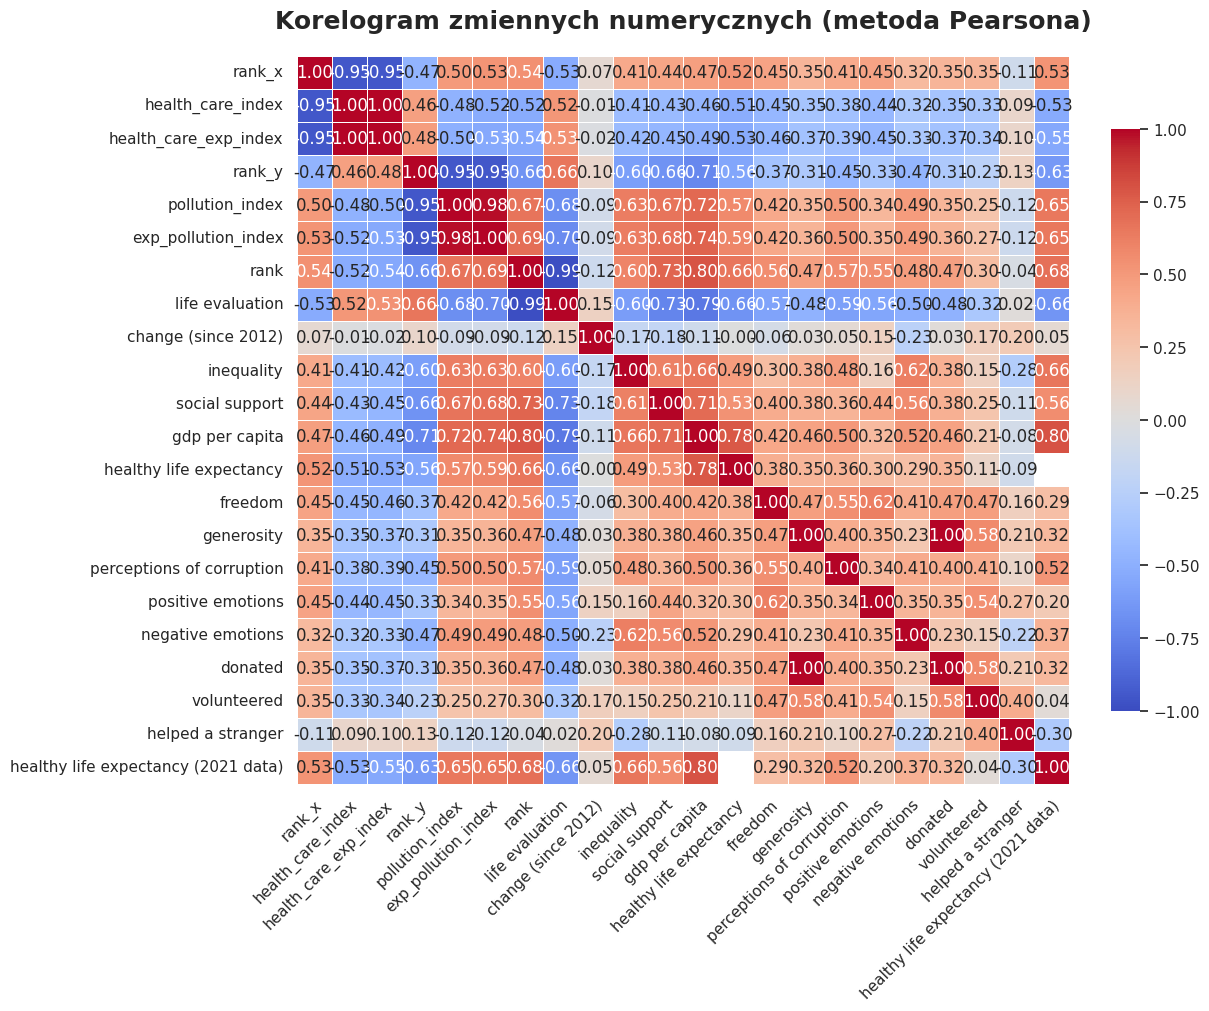

In [426]:
wykres_korelacji(polaczone_dane_nowe)

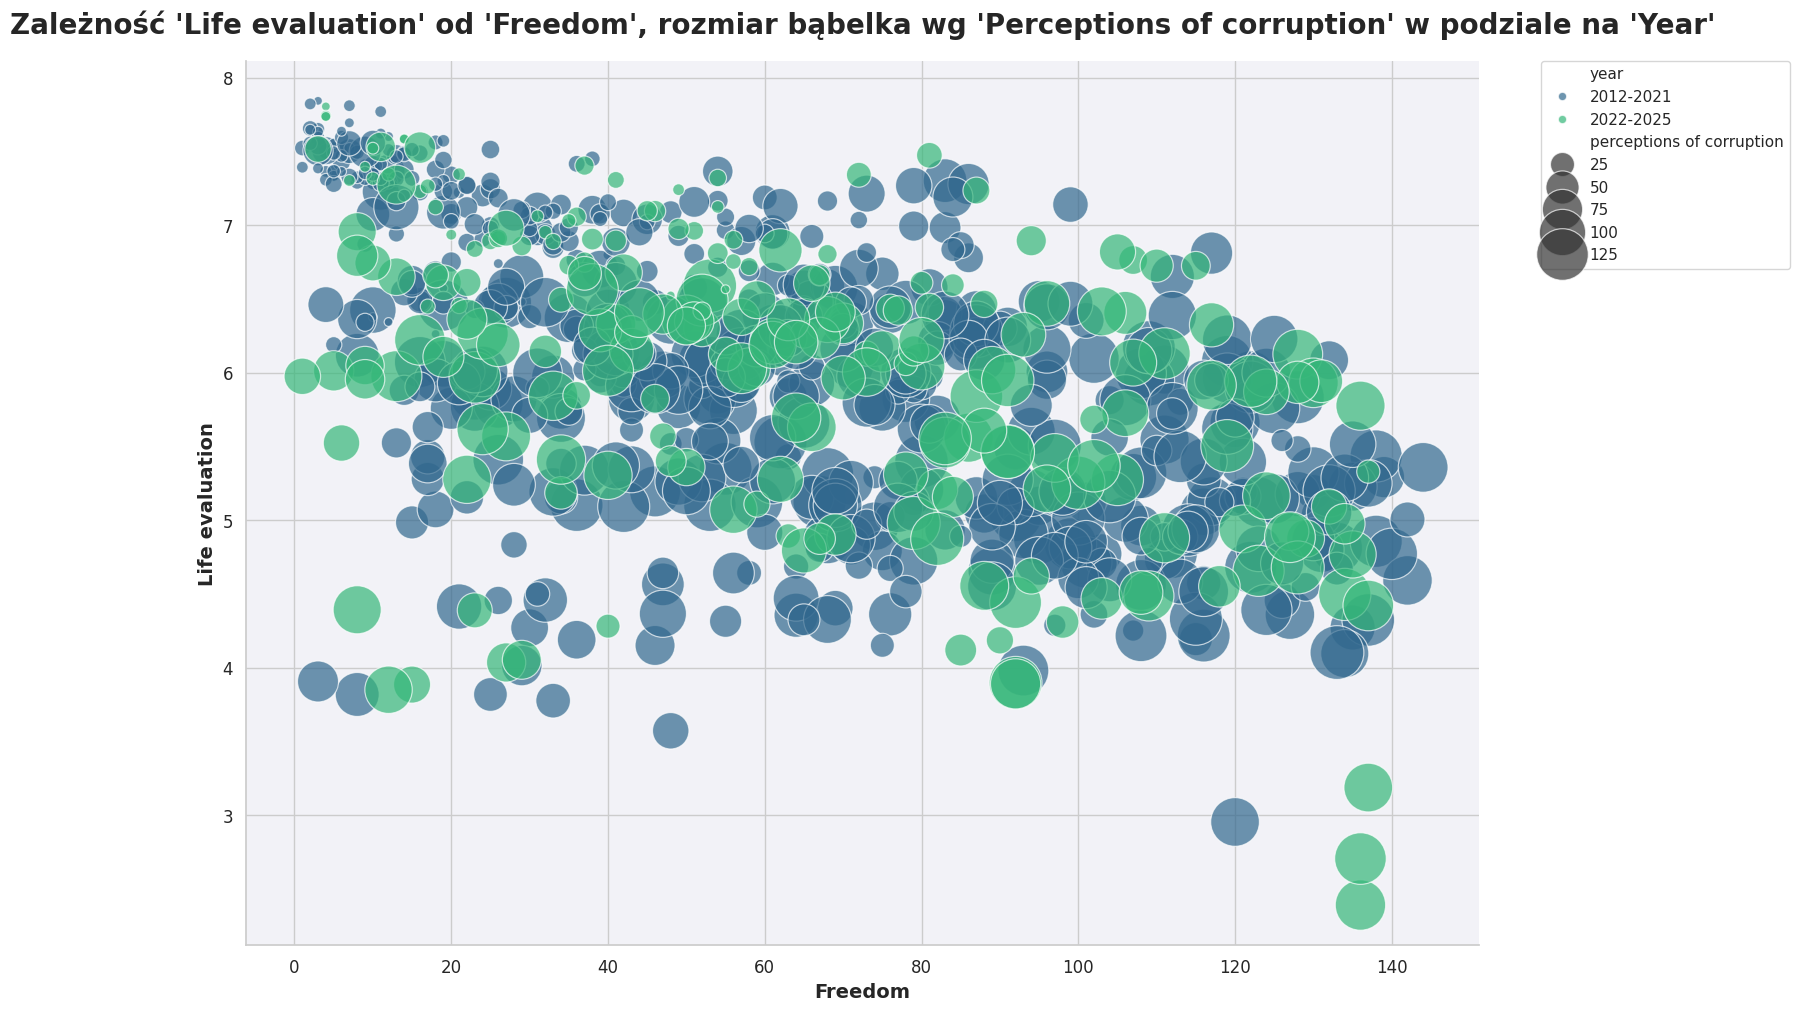

In [427]:
wykres_babelkowy(polaczone_dane_nowe, "freedom", "life evaluation", "perceptions of corruption", "year")

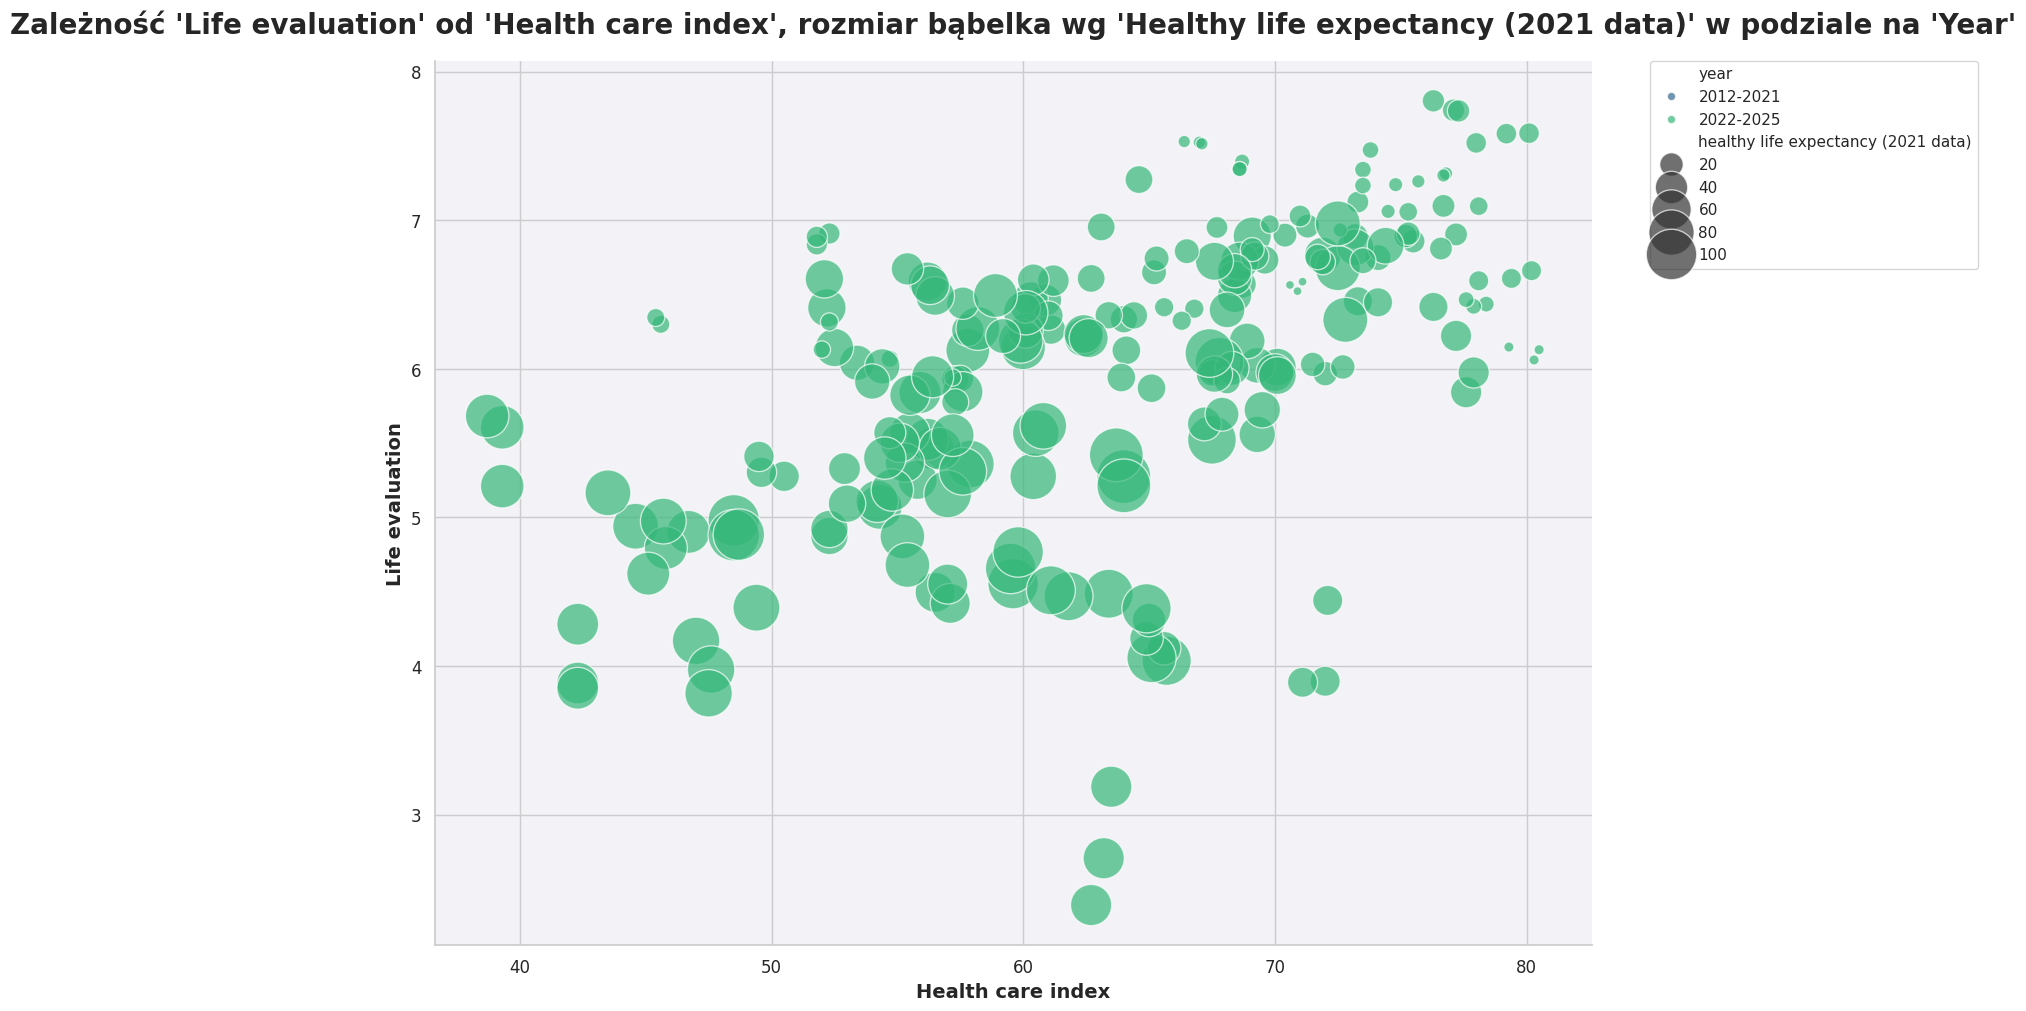

In [428]:
wykres_babelkowy(polaczone_dane_nowe, "health_care_index", "life evaluation", "healthy life expectancy (2021 data)", "year")